In [12]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [13]:
EPOCHS = 15
BATCH_SIZE = 64

In [14]:
# setting the transforms and normalizing the images
train_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
])
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
])

In [15]:
# creating train and test dataset
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [16]:
SEED = 22

cuda = torch.cuda.is_available()
print(cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


True


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


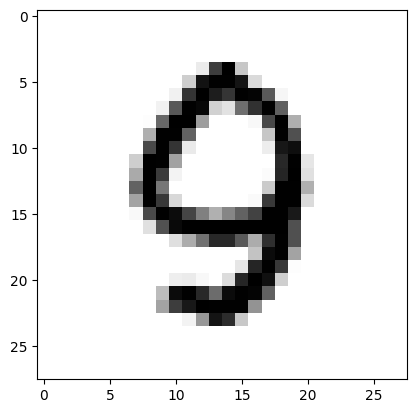

In [17]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

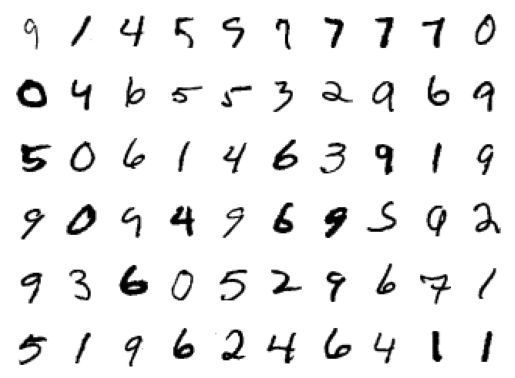

In [18]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [19]:
# dropout 
dropout = 0.05
# lets start with basic model skeleton with batchnorm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input block 
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout)
        ) # out = 26
        # Conv block 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout)
        ) # out = 24
        # Transition block 
        self.convblock3 = nn.Sequential(
            nn.Conv2d(32, 8, kernel_size=(1, 1), padding=0, bias=False)
        ) # out = 24
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # out = 12
        # Conv block 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout)
        ) # out = 10
        # Conv block 3
        self.convblock5 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout)
        ) # out = 10
        # conv block 4
        self.convblock6 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout)
        ) # out = 8
        self.convblock7 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout)
        ) # out = 6
        self.gap = nn.AvgPool2d(kernel_size=6) # out = 1
        # output layer
        self.convblock8 = nn.Sequential(nn.Conv2d(16, 10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x) # Rin = 1 | Rout = 3
        x = self.convblock2(x) # Rin = 3 | Rout = 5
        x = self.convblock3(x) # Rin = 5 | Rout = 5
        x = self.pool1(x) # Rin = 5 | Rin = 6
        x = self.convblock4(x) # Rin = 6 | Rout = 10
        x = self.convblock5(x) # Rin = 6 | Rout = 14
        x = self.convblock6(x) # Rin = 14 | Rout = 18
        x = self.convblock7(x) # Rin = 18 | Rout = 22
        x = self.gap(x) # Rin = 22 | Rout = 32
        x = self.convblock8(x) # Rin = 32 | Rout = 32
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)


In [20]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
       BatchNorm2d-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             576
      BatchNorm2d-12            [-1, 8, 10, 10]              16
             ReLU-13            [-1, 8, 10, 10]               0
          Dropout-14            [-

In [21]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [22]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07917597889900208 Batch_id=468 Accuracy=79.80: 100%|██████████| 469/469 [00:06<00:00, 69.97it/s] 



Test set: Average loss: 0.1379, Accuracy: 9628/10000 (96.28%)

EPOCH: 1


Loss=0.11121035367250443 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:06<00:00, 70.50it/s]  



Test set: Average loss: 0.1012, Accuracy: 9713/10000 (97.13%)

EPOCH: 2


Loss=0.017314458265900612 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:06<00:00, 67.99it/s] 



Test set: Average loss: 0.0610, Accuracy: 9828/10000 (98.28%)

EPOCH: 3


Loss=0.0778646394610405 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:06<00:00, 75.80it/s]   



Test set: Average loss: 0.0501, Accuracy: 9848/10000 (98.48%)

EPOCH: 4


Loss=0.16910213232040405 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:06<00:00, 73.33it/s]  



Test set: Average loss: 0.0414, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.06545291095972061 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:06<00:00, 76.65it/s]  



Test set: Average loss: 0.0402, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.0460159033536911 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:06<00:00, 68.92it/s]   



Test set: Average loss: 0.0301, Accuracy: 9903/10000 (99.03%)

EPOCH: 7


Loss=0.018590420484542847 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:06<00:00, 77.18it/s]  



Test set: Average loss: 0.0314, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.02608651854097843 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:06<00:00, 70.85it/s]  



Test set: Average loss: 0.0313, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.04414602741599083 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:06<00:00, 68.84it/s]  



Test set: Average loss: 0.0264, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.061250943690538406 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:07<00:00, 61.77it/s] 



Test set: Average loss: 0.0252, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.03209947422146797 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:07<00:00, 64.50it/s]  



Test set: Average loss: 0.0258, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.05681567266583443 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:07<00:00, 66.61it/s]  



Test set: Average loss: 0.0283, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.12390228360891342 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:08<00:00, 57.48it/s]  



Test set: Average loss: 0.0251, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.036920614540576935 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:06<00:00, 68.29it/s]  



Test set: Average loss: 0.0259, Accuracy: 9930/10000 (99.30%)

